In [1]:
from __future__ import division, print_function, absolute_import
import csv
import pandas
from cobra.flux_analysis import (
    single_gene_deletion, single_reaction_deletion, double_gene_deletion,
    double_reaction_deletion)
import os
import xml.etree.ElementTree as etree
import cobra
import numpy as np
from itertools import chain
from cobra.util import solver as sutil
from cobra.core.solution import get_solution
from optlang.symbolics import add, Zero
import pandas as pd
import os
from os.path import join
import matplotlib.pyplot as plt
from cobra.medium import minimal_medium
# Press ⌃R to execute it or replace it with your code.
# Press Double ⇧ to search everywhere for classes, files, tool windows, actions, and settings.
from cobra.flux_analysis import production_envelope
from cobra import Model, Reaction, Metabolite
from cobra.flux_analysis import flux_variability_analysis
import matplotlib.pyplot as plt
from cobra.io import load_json_model, save_json_model, load_matlab_model, save_matlab_model, read_sbml_model, write_sbml_model
import math

In [2]:
## pareto
objective1={''}
objective2={''}
pareto_range = (0.0, 1.001)  # for some reason you need to pick a number higher than 1).
pareto_step_size = 0.01
analysis_type = 'pareto'
metric = 'manhattan'
rxn2avoid = {''}
primary=[]
solver='gurobi'
constants = {'deltaC_CO2': 0.0055, 'D_H2O_0': 2.13E-05, 'D_CO2_0': 1.33E-05, 'mid_day': 6, 'deltaT': 2,
             'FeasTol': 1e-03, 'OptTol': 1e-03}
def pareto_analysis(model, objective1=objective1, objective2=objective2, pareto_range=pareto_range, metric=metric,primary=primary):
    reaction_obj1 = model.reactions.get_by_id(objective1)
    reaction_obj2 = model.reactions.get_by_id(objective2)
    result_list = []
    solution_primary=[]
    model.objective = {}
    reaction_obj1.objective_coefficient = 1
    solution = model.optimize()
    print("\nSolving model (FBA) for determining objective 1 flux...")
    max_obj1 = dict(solution.fluxes)[objective1]
    print("Max {0}: {1}".format(objective1, max_obj1))
    # change objective
    reaction_obj1.objective_coefficient = 0
    reaction_obj2.objective_coefficient = 1
    print("\nSolving all iterations for Pareto frontier (FBA)...")
    for pareto in np.arange(pareto_range[0], pareto_range[1], pareto_step_size):
        if pareto == 1:
            reaction_obj1.lower_bound = max_obj1 * pareto  # * 0.999 # we need to add a bit of slack as the quadratic optimization is less accurate than the linear couterpart
        else:
            reaction_obj1.lower_bound = max_obj1 * pareto  # * 0.9999
        sol = model.optimize(objective_sense='maximize')
        # fix this minimal water loss value
        reaction_obj2.bounds = (sol.get_primal_by_id(objective2), sol.get_primal_by_id(objective2))
        if metric == 'manhattan':
            solution = cobra.flux_analysis.pfba(model)
            primary_dark=[]
            for i in model.reactions:
                primary_dark.append(i.id)
            solution_primary.append(solution.fluxes[primary_dark])
            reaction_obj2.bounds = (0, 1000.0)
        elif metric == 'euclidean':

            # make copy because that is easier that reverting all the solver settings
            copy_model = model.copy()
            model.solver = solver

            FeasTol = float(constants['FeasTol'])
            OptTol = float(constants['OptTol'])

            copy_model.solver.configuration.tolerances.feasibility = FeasTol
            copy_model.solver.configuration.tolerances.optimality = OptTol

            rxnlist = [r for r in copy_model.reactions if r.id not in rxn2avoid]

            obj_vars = chain.from_iterable([r.flux_expression ** 2] for r in rxnlist)
            copy_model.objective = copy_model.problem.Objective(add(obj_vars), direction='min')

            print('\nSolving quadratic minimisation of sum of fluxes')
            #print(solver)
            solution = copy_model.optimize(objective_sense=None)
            #result_list.append([pareto, solution[objective1], solution[objective2]])
        reaction_obj2.bounds = (0, 1000.0)
    #return result_list
    return solution_primary

In [3]:
## Plots
#model = cobra.io.load_matlab_model(join('/home/subasree/Desktop/Models_to_work/alpha_day_DM.mat'))
model_rs = read_sbml_model('/Users/subasrees/Desktop/Core_Model_Simulations/beta_antiox_dm.xml')
core_model=model_rs

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-16


In [4]:
## biotic
#h2o2_biotic = core_model.problem.Constraint(core_model.reactions.get_by_id("H2O2_p_demand").flux_expression + core_model.reactions.get_by_id("H2O2_m_demand").flux_expression + core_model.reactions.get_by_id("H2O2_x_demand").flux_expression + core_model.reactions.get_by_id("H2O2_e_demand").flux_expression, lb=0, ub=0.002339457096)
#core_model.add_cons_vars(h2o2_biotic)
#
#o2s_biotic = core_model.problem.Constraint(core_model.reactions.get_by_id("Super_oxide_p_demand").flux_expression + core_model.reactions.get_by_id("Super_oxide_m_demand").flux_expression + core_model.reactions.get_by_id("Super_oxide_x_demand").flux_expression, lb=0, ub=0.00440746474)
#core_model.add_cons_vars(o2s_biotic)

## drought
#h2o2_drought = core_model.problem.Constraint(core_model.reactions.get_by_id("H2O2_p_demand").flux_expression + core_model.reactions.get_by_id("H2O2_m_demand").flux_expression + core_model.reactions.get_by_id("H2O2_x_demand").flux_expression + core_model.reactions.get_by_id("H2O2_e_demand").flux_expression, lb=0, ub=13.24)
#core_model.add_cons_vars(h2o2_drought)

##
h2o2_uvb = core_model.problem.Constraint(core_model.reactions.get_by_id("H2O2_p_demand").flux_expression + core_model.reactions.get_by_id("H2O2_m_demand").flux_expression + core_model.reactions.get_by_id("H2O2_x_demand").flux_expression, lb=0, ub=7.476968447)
#core_model.add_cons_vars(h2o2_uvb)
#
o2s_uvb = core_model.problem.Constraint(core_model.reactions.get_by_id("Super_oxide_p_demand").flux_expression + core_model.reactions.get_by_id("Super_oxide_m_demand").flux_expression + core_model.reactions.get_by_id("Super_oxide_x_demand").flux_expression, lb=0, ub=0.0001540487974)
#core_model.add_cons_vars(o2s_uvb)

## ellicitors
#2o2_ell = core_model.problem.Constraint(core_model.reactions.get_by_id("H2O2_p_demand").flux_expression + core_model.reactions.get_by_id("H2O2_m_demand").flux_expression + core_model.reactions.get_by_id("H2O2_x_demand").flux_expression + core_model.reactions.get_by_id("H2O2_e_demand").flux_expression, lb=0, ub=0.03415905925)
#core_model.add_cons_vars(h2o2_ell)
#
#o2s_ell = core_model.problem.Constraint(core_model.reactions.get_by_id("Super_oxide_p_demand").flux_expression + core_model.reactions.get_by_id("Super_oxide_m_demand").flux_expression + core_model.reactions.get_by_id("Super_oxide_x_demand").flux_expression, lb=0, ub=0.00585384449)
#core_model.add_cons_vars(o2s_ell)

## Nitric oxide
#h2o2_demand = core_model.problem.Constraint(core_model.reactions.get_by_id("DM_NITRIC-OXIDE_cell").flux_expression, lb=0, ub=0.0001802061558)
#core_model.add_cons_vars(h2o2_demand)


In [5]:
##Constraints
rubisco = core_model.problem.Constraint(1 * core_model.reactions.get_by_id("RXN_961_p").flux_expression - core_model.reactions.get_by_id("RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p").flux_expression,lb=0, ub=0,)
core_model.add_cons_vars([rubisco])

atp = core_model.problem.Constraint((0.0049*core_model.reactions.get_by_id("Photon_tx").flux_expression+2.7851)-core_model.reactions.get_by_id("ATPase_tx").flux_expression, lb=0, ub=0)
core_model.add_cons_vars(atp)

atp_nadph_03 = core_model.problem.Constraint(3 * (core_model.reactions.get_by_id("NADPHoxm_tx").flux_expression + core_model.reactions.get_by_id("NADPHoxc_tx").flux_expression + core_model.reactions.get_by_id("NADPHoxp_tx").flux_expression) - core_model.reactions.get_by_id("ATPase_tx").flux_expression, lb=0, ub=0)
core_model.add_cons_vars(atp_nadph_03)

In [6]:
## plot pareto plot
objective1 =  'DM_HYDROGEN_PEROXIDE_cell' #ho2_rad_p_demand AraCore_Biomass_tx DM_HS_cell DM_CPD0-1395_cell'DM_SUPER_OXIDE_cell'#'DM_NITRIC-OXIDE_cell'#'DM_CPD-12377_cell'#'DM_HYDROGEN_PEROXIDE_cell'
objective2 =  'AraCore_Biomass_tx'#Arabidopsis_biomass_tx' 'AraCore_Biomass_tx'
solution_primary=pareto_analysis(core_model, objective1 = objective1, objective2=objective2, pareto_range = pareto_range, metric = metric)
#pd.DataFrame(result_list).to_excel('results.xlsx')



Solving model (FBA) for determining objective 1 flux...
Max DM_HYDROGEN_PEROXIDE_cell: 95.77869582066648

Solving all iterations for Pareto frontier (FBA)...


In [7]:
data=pd.DataFrame(solution_primary)
data_t=data.T
solution_frame=pd.DataFrame(data_t.iloc[:,0])
solution_frame.columns=['fluxes']

In [8]:
#Creating an empty dataframe
df_p = []
df_c = []

## H2O2
budget_metabolites=["HYDROGEN_PEROXIDE_c","HYDROGEN_PEROXIDE_m","HYDROGEN_PEROXIDE_p","HYDROGEN_PEROXIDE_x","HYDROGEN_PEROXIDE_v","HYDROGEN_PEROXIDE_e","HYDROGEN_PEROXIDE_g","HYDROGEN_PEROXIDE_n"]
compartment = ["_c", "_m", "_p", "_x","_v","_e","_g","_n"]

#budget_metabolites=["HYDROGEN_PEROXIDE_cell"]
#compartment = ["_cell"]

#budget_metabolites=["SUPER_OXIDE_c","SUPER_OXIDE_m","SUPER_OXIDE_p","SUPER_OXIDE_x","SUPER_OXIDE_v","SUPER_OXIDE_e","SUPER_OXIDE_n"]
#compartment = ["_c", "_m", "_p", "_x","_v","_e","_g"]

#budget_metabolites=["SUPER_OXIDE_cell"]
#compartment = ["_cell"]

#budget_metabolites=["NITRIC-OXIDE_n","NITRIC-OXIDE_c","NITRIC-OXIDE_m","NITRIC-OXIDE_p","NITRIC-OXIDE_x","NITRIC-OXIDE_e"]
#compartment = ["_n","_c", "_m", "_p", "_x","_e"]

#budget_metabolites=["NITRIC-OXIDE_cell"]
#compartment = ["_cell"]

c3_model=core_model
for (a,com) in zip(budget_metabolites,compartment):
    i = c3_model.metabolites.get_by_id(a).summary()
    p = i.producing_flux
    c = i.consuming_flux

# Retrieving the reactions using pandas and filtering the transport reactions
    producer = p#.loc[:,"reaction"].str.endswith(com) 
    print(producer)
    df_p.append(producer)
    producer_df = pd.concat(df_p)
        
# Retrieving the reactions using pandas
    consumer = c#.loc[:,"reaction"].str.endswith(com)
    df_c.append(consumer)
    consumer_df = pd.concat(df_c)
consumers=list(consumer_df['reaction'])
producers=list(producer_df.index)

                           flux               reaction  percent
RS_33                  0.000000                  RS_33      0.0
RS_34                  0.000000                  RS_34      0.0
RS_Plant_ALDO_C        0.000000        RS_Plant_ALDO_C      0.0
RS_Plant_PSD2_nad_Mb   0.000000   RS_Plant_PSD2_nad_Mb      0.0
RS_Plant_PSD2_nadp_Mb  0.000000  RS_Plant_PSD2_nadp_Mb      0.0
SUPEROX_DISMUT_RXN_c   7.490006   SUPEROX_DISMUT_RXN_c      1.0
                           flux               reaction  percent
RS_Plant_SOD_M         0.000000         RS_Plant_SOD_M      0.0
SULFITE_OXIDASE_RXN_m  4.357005  SULFITE_OXIDASE_RXN_m      1.0
                           flux              reaction   percent
RS_35_CP               0.000000              RS_35_CP  0.000000
RS_46_CP               0.000000              RS_46_CP  0.000000
RS_74_CP               0.000000              RS_74_CP  0.000000
RS_Plant_2_P          80.802784          RS_Plant_2_P  0.915169
SUPEROX_DISMUT_RXN_p   7.490006  SUPEROX

In [9]:
#Get flux values from the simulation for metabolite consuming/producing reactions (correct list)
producers_df = solution_frame.loc[producers,:]
#Make all values positive (disregard directionality)
producers_df["fluxes"] = producers_df["fluxes"].abs()
#Remove reactions with zero flux
producers_df = producers_df[(producers_df.T != 0).all()]


#Get flux values from the simulation for metabolite consuming/producing reactions (correct list)
consumers_df = solution_frame.loc[consumers,:]
#Make all values positive (disregard directionality)
consumers_df["fluxes"]  = consumers_df["fluxes"].abs()
#Remove reactions with zero flux3_P_SERINE_
consumers_df = consumers_df[(consumers_df.T != 0).all()]


producers_df["Status"] = "Producer"
consumers_df["Status"] = "Consumer"

frame = [producers_df, consumers_df]

all_reactions = pd.concat(frame)

all_reactions["label"] = all_reactions.index
print(all_reactions)


#Correct Budget stoichiometry
met_stoi=[]
for i in all_reactions['label']:
    for met in budget_metabolites:
        try:
            rxn=c3_model.reactions.get_by_id(i).get_coefficient(met)
            met_stoi.append(abs(rxn))
        except KeyError:
            continue

new_flux = all_reactions["fluxes"] * met_stoi

all_reactions.insert(3,'coefficient', met_stoi)
all_reactions.insert(4,'new_flux', new_flux)

#Sum the flux values
#print("Sum of fluxes: {}".format(all_reactions.groupby(["Status"]).new_flux.sum()))
print(len(all_reactions.index))

                                 fluxes    Status  \
SUPEROX_DISMUT_RXN_c           7.490006  Producer   
SULFITE_OXIDASE_RXN_m          4.357005  Producer   
SUPEROX_DISMUT_RXN_p           7.490006  Producer   
RXN_969_x                     10.176113  Producer   
H2O2_c_demand                  7.490006  Consumer   
RS_Plant_CAT_M                 2.178502  Consumer   
H2O2_p_demand                  7.485906  Consumer   
L_ASCORBATE_PEROXIDASE_RXN_p   0.004100  Consumer   
CATAL_RXN_x                    5.088057  Consumer   

                                                     label  
SUPEROX_DISMUT_RXN_c                  SUPEROX_DISMUT_RXN_c  
SULFITE_OXIDASE_RXN_m                SULFITE_OXIDASE_RXN_m  
SUPEROX_DISMUT_RXN_p                  SUPEROX_DISMUT_RXN_p  
RXN_969_x                                        RXN_969_x  
H2O2_c_demand                                H2O2_c_demand  
RS_Plant_CAT_M                              RS_Plant_CAT_M  
H2O2_p_demand                             

In [10]:
import random
import matplotlib.pyplot as plt
#Getting a list of colors
random.seed(255)
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
            for i in range(22)]
color_save=color[11:]
color_rev_save=color[:11]

In [11]:
#Defining the no of colors
number_of_colors = len(all_reactions.index)
#Getting list of reactions
reaction_list = list(all_reactions.index)
reaction_list.sort()
#Build color dictionary
color_dict = {}
for i in range(len(reaction_list)):
    #if reaction_list[i] in reaction_list_save:
        color_dict[reaction_list[i]] = color[i]
    #else:
        #color_dict[reaction_list[i]] = color_rev[i]
print(color_dict)

{'CATAL_RXN_x': '#1A1B48', 'H2O2_c_demand': '#C9E5E9', 'H2O2_p_demand': '#D24B96', 'L_ASCORBATE_PEROXIDASE_RXN_p': '#EAEC46', 'RS_Plant_CAT_M': '#8B6DD7', 'RXN_969_x': '#2C398F', 'SULFITE_OXIDASE_RXN_m': '#C65937', 'SUPEROX_DISMUT_RXN_c': '#978DDB', 'SUPEROX_DISMUT_RXN_p': '#5B81D3'}


In [12]:
color=color_save
color_rev=color_rev_save
reaction_list_save=reaction_list

<Figure size 10000x7000 with 0 Axes>

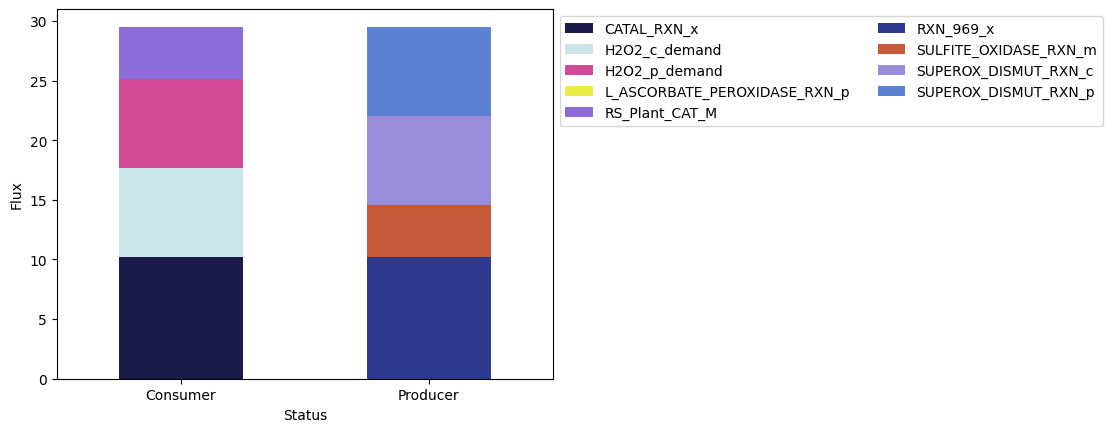

In [13]:
fig = plt.figure()
plt.style.use('fast')
chart = all_reactions.pivot_table(index="Status", columns="label", values="new_flux")
chart.plot.bar(rot = 0, stacked = True, legend = True, ylabel = "Flux", color = color_dict)
plt.legend(loc='best', bbox_to_anchor=(1.0, 0.5, 0.5, 0.5), ncol = 2)
#plt.title("Platoquinone Turnover in the Bundle Sheath Cell")
figsize = [15, 20] #To prevent the cropping of the image
fig.set_size_inches(w=100,h=70)
fig.tight_layout()
#plt.savefig('full_max_o2s.pdf')

In [14]:
#Defining the no of colors
number_of_colors = len(all_reactions.index)
#Getting list of reactions
reaction_list_new = list(all_reactions.index)
reaction_list_new.sort()
#Build color dictionary
color_dict_new = {}
for i in reaction_list_new:
    if i in reaction_list_save:
        color_dict_new[i] = color_dict[i]
    else:
        j=0
        color_dict_new[i] = color_rev[j]
        j+1
print(color_dict_new)

{'CATAL_RXN_x': '#1A1B48', 'H2O2_c_demand': '#C9E5E9', 'H2O2_p_demand': '#D24B96', 'L_ASCORBATE_PEROXIDASE_RXN_p': '#EAEC46', 'RS_Plant_CAT_M': '#8B6DD7', 'RXN_969_x': '#2C398F', 'SULFITE_OXIDASE_RXN_m': '#C65937', 'SUPEROX_DISMUT_RXN_c': '#978DDB', 'SUPEROX_DISMUT_RXN_p': '#5B81D3'}


<Figure size 10000x7000 with 0 Axes>

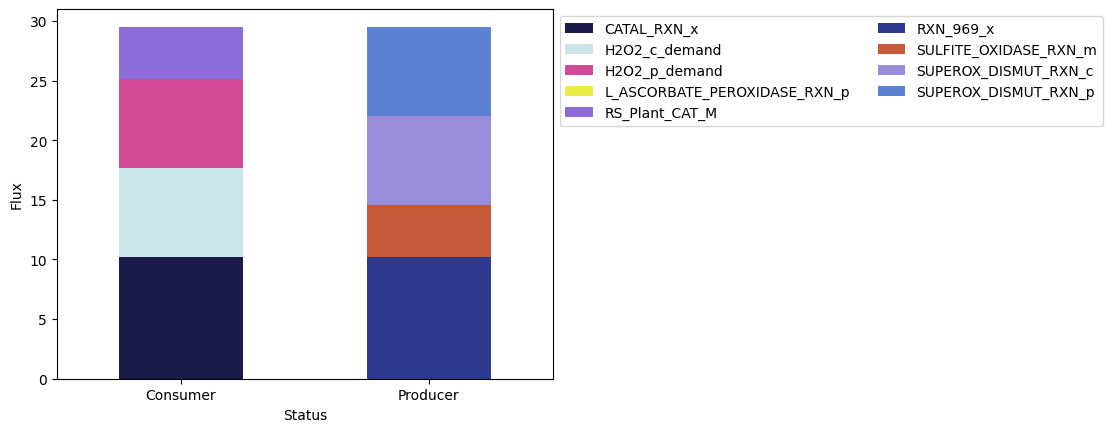

label,CATAL_RXN_x,H2O2_c_demand,H2O2_p_demand,L_ASCORBATE_PEROXIDASE_RXN_p,RS_Plant_CAT_M,RXN_969_x,SULFITE_OXIDASE_RXN_m,SUPEROX_DISMUT_RXN_c,SUPEROX_DISMUT_RXN_p
Status,,,,,,,,,
Consumer,10.176113,7.490006,7.485906,0.0041,4.357005,NaN,NaN,NaN,NaN
Producer,NaN,NaN,NaN,NaN,NaN,10.176113,4.357005,7.490006,7.490006


In [15]:
fig = plt.figure()
plt.style.use('fast')
chart = all_reactions.pivot_table(index="Status", columns="label", values="new_flux")
chart.plot.bar(rot = 0, stacked = True, legend = True, ylabel = "Flux", color = color_dict_new)
plt.legend(loc='best', bbox_to_anchor=(1.0, 0.5, 0.5, 0.5), ncol = 2)
#plt.title("Platoquinone Turnover in the Bundle Sheath Cell")
figsize = [15, 20] #To prevent the cropping of the image
fig.set_size_inches(w=100,h=70)
fig.tight_layout()
#plt.savefig('full_max_o2s.pdf')
plt.show()
chart